In [1]:
import numpy as np
import pandas as pd
from dstk.utils.data_cleaning import clean_columns

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('dark')
plt.rcParams['figure.figsize'] = (9,6)
np.set_printoptions(suppress=True)
pd.options.display.max_columns = 150

In [2]:
def col_descrip(table, col):
    "Looks up column description for given table"
    print(table)
    print(col)
    return col_des.loc[(col_des.Table==table) & (col_des.Row==col.upper()),
            'Description'].values[0]

def anom_eval(df, col, filename):
    print(col_descrip(filename, col))
    print()

    max_diff_idx = df[col].sort_values().diff().nlargest(3).index
    max_diffs = df.loc[max_diff_idx, col]
    nlargest = df[col].nlargest()
    nsmallest = df[col].nsmallest()

    print('Max Diffs')
    print(max_diffs)
    print()
    print("Largest Vals")
    print(nlargest)
    print()
    print("Smallest Vals")
    print(nsmallest)
    df[col].hist()
    df[col].value_counts().sort_index()

    return max_diffs, nlargest

def pct_null(df):
    null_counts = df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False).to_frame()
    if null_counts.empty:
        return None
    null_counts['pct_null'] = null_counts/df.shape[0]
    null_counts.columns = ['n_null', 'pct_null']
    return null_counts

In [3]:
col_des = pd.read_csv('HomeCredit_columns_description.csv', encoding='latin-1')
col_des.shape

(219, 5)

In [6]:
bureau = pd.read_csv("raw_data/bureau.csv.zip", dtype= {'SK_ID_CURR':str, 'SK_ID_BUREAU':str})
bureau.shape

(1716428, 17)

In [7]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
list(
    zip(col_des[col_des.Table=='bureau.csv'].Row.tolist(),col_des[col_des.Table=='bureau.csv'].Description.tolist())
)

[('SK_ID_CURR',
  'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '),
 ('SK_BUREAU_ID',
  'Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)'),
 ('CREDIT_ACTIVE', 'Status of the Credit Bureau (CB) reported credits'),
 ('CREDIT_CURRENCY', 'Recoded currency of the Credit Bureau credit'),
 ('DAYS_CREDIT',
  'How many days before current application did client apply for Credit Bureau credit'),
 ('CREDIT_DAY_OVERDUE',
  'Number of days past due on CB credit at the time of application for related loan in our sample'),
 ('DAYS_CREDIT_ENDDATE',
  'Remaining duration of CB credit (in days) at the time of application in Home Credit'),
 ('DAYS_ENDDATE_FACT',
  'Days since CB credit ended at the time of application in Home Credit (only for closed credit)'),
 ('AMT_CREDIT_MAX_OVERDUE',
  'Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in

In [10]:
bureau_balances = pd.read_csv('raw_data/bureau_balance.csv.zip',  dtype={'SK_ID_CURR':str, 'SK_ID_BUREAU':str})
bureau_balances.shape

(27299925, 3)

In [11]:
bureau_balances.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [12]:
list(
    zip(col_des[col_des.Table=='bureau_balance.csv'].Row.tolist(),col_des[col_des.Table=='bureau_balance.csv'].Description.tolist())
)

[('SK_BUREAU_ID',
  'Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table '),
 ('MONTHS_BALANCE',
  'Month of balance relative to application date (-1 means the freshest balance date)'),
 ('STATUS',
  'Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )')]

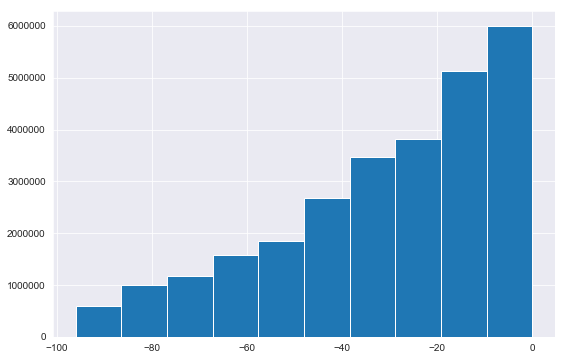

In [13]:
# Most lones were short term?
bureau_balances.MONTHS_BALANCE.hist()

## Cleaning

Ordered Columns By Type:
    - Primary Key and Target
    - Object
    - Int + Float = Numeric
    - Indicators (parsed from int cols)

Evaluated Numeric Anomalies:
    - Looked far large gaps in the ordered values of each column
    - Evaluated manually, replaced anoms with col medians
    - Created indicator cols for anom rows

Fill NAs:
    - Object Cols filled with either most frequent value or with "MISSING" which will be turned into an indicator
    - Numeric imputed with median

Encode Obj Cols:
    - Binary columns turned into 0s/1s
    - Multi-val columns OHE

### Column Types

In [14]:
bureau.dtypes.value_counts()

float64    8
object     5
int64      4
dtype: int64

In [15]:
bureau.columns = clean_columns(bureau)
pks = ['sk_id_curr', 'sk_id_bureau']

obj_cols = bureau.dtypes[bureau.dtypes == 'object'].index.tolist()
obj_cols = [col for col in obj_cols if col not in pks]
int_cols = bureau.dtypes[bureau.dtypes == 'int64'].index.tolist()
float_cols = bureau.dtypes[bureau.dtypes == 'float64'].index.tolist()
numeric_cols = int_cols + float_cols
indicator_cols = bureau[numeric_cols].columns[bureau[numeric_cols].apply(lambda s: s.nunique())==2].tolist()

# remove indicator cols from numeric cols
int_cols = [i for i in int_cols if i not in indicator_cols]
float_cols = [i for i in float_cols if i not in indicator_cols]
numeric_cols = int_cols + float_cols


ordered_cols = sorted(pks) + sorted(obj_cols) + sorted(int_cols) + sorted(float_cols) + sorted(indicator_cols)
print(bureau.shape, len(ordered_cols))
bureau = bureau[ordered_cols]

(1716428, 17) 17


### Anomalies

In [16]:
neg_cols = bureau[numeric_cols].columns[bureau[numeric_cols].apply(lambda ser: (ser < 0).any())].tolist()
for col in neg_cols:
    print(col)
    bureau.loc[bureau[col]<0, col] *= -1

days_credit
days_credit_update
days_credit_enddate
days_enddate_fact
amt_credit_sum_debt
amt_credit_sum_limit


In [14]:
gaps = bureau[numeric_cols].apply(lambda s: s.sort_values().diff().max()/s.std())
gaps[gaps>2]

cnt_credit_prolong         10.392428
days_credit_update         54.018977
days_credit_enddate         2.269330
days_enddate_fact          54.594426
amt_credit_max_overdue    377.914034
amt_credit_sum            196.467013
amt_credit_sum_debt       145.546632
amt_credit_sum_limit       19.724401
amt_credit_sum_overdue    217.902873
amt_annuity                95.282754
dtype: float64

In [15]:
cols = [
    'days_credit_update',
    'days_credit_enddate',
    'days_enddate_fact',
    'amt_credit_max_overdue',
    'amt_annuity',

    'amt_credit_sum',
    'amt_credit_sum_debt',
    'amt_credit_sum_limit',
    'amt_credit_sum_overdue',

]

In [16]:
anom_eval(bureau, 'amt_credit_sum_overdue', 'bureau.csv')

bureau.csv
amt_credit_sum_overdue
Current amount overdue on Credit Bureau credit

Max Diffs
1689290    3681063.0
188140     2387232.0
1430899    1617403.5
Name: amt_credit_sum_overdue, dtype: float64

Largest Vals
940407     3756681.0
1689290    3681063.0
188140     2387232.0
271894     1851210.0
1430899    1617403.5
Name: amt_credit_sum_overdue, dtype: float64

Smallest Vals
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: amt_credit_sum_overdue, dtype: float64


(1689290    3681063.0
 188140     2387232.0
 1430899    1617403.5
 Name: amt_credit_sum_overdue, dtype: float64, 940407     3756681.0
 1689290    3681063.0
 188140     2387232.0
 271894     1851210.0
 1430899    1617403.5
 Name: amt_credit_sum_overdue, dtype: float64)

In [17]:
for col in cols:
    print(col)
    max_diff_idx = bureau[col].sort_values().diff().nlargest(1).index
    max_diff = bureau.loc[max_diff_idx, col].squeeze()
    denom = int(np.log10(max_diff))

    if denom < 2:
        # if we are only in the 10s palce leave it
        cutoff = max_diff
    else:
        # if we are greater than the 10s place round down
        cutoff = int(max_diff/(10**denom))*(10**denom)

    anoms = bureau.loc[bureau[col]>=cutoff, col]
    rest = bureau.loc[~bureau.index.isin(anoms.index), col]

    # replace outliers with median from non-outlying data
    bureau.loc[anoms.index, col] = rest.median()


    # create identifier for anomalies
    bureau[col+'_anom'] = 0
    bureau.loc[anoms.index, col+'_anom'] = 1


    # add to indicator columns
    indicator_cols.append(col+'_anom')

days_credit_update
days_credit_enddate
days_enddate_fact
amt_credit_max_overdue
amt_annuity
amt_credit_sum
amt_credit_sum_debt
amt_credit_sum_limit
amt_credit_sum_overdue


### FILL NA

In [18]:
# No missing obj cols
obj_nulls = pct_null(bureau[obj_cols])
obj_nulls

In [19]:
# numeric nulls fill w median
medians = bureau[numeric_cols].median().squeeze()
bureau.fillna(medians, inplace=True)

### Encoding Cat Vars

In [20]:
bureau.columns[bureau.nunique() < 2]

Index([], dtype='object')

In [21]:
# No Binary Columns?
binary_cols = bureau[obj_cols].nunique()[bureau[obj_cols].nunique() ==2].index.tolist()
binary_cols

[]

In [22]:
# One hot encode
non_binary_cats = [col for col in obj_cols if col not in binary_cols]
non_binary_cats

['credit_active', 'credit_currency', 'credit_type']

In [23]:
for col in non_binary_cats:
    print(col)
    ohe = pd.get_dummies(bureau[col]) # drop_first?
    ohe.columns = col + '_' + ohe.columns

    # now drop first
    ohe.drop(ohe.columns[0], axis=1, inplace=True)


    bureau = pd.concat([bureau, ohe], axis=1)
    del bureau[col]
    obj_cols.remove(col)
    indicator_cols.extend(ohe.columns.tolist())

credit_active
credit_currency
credit_type


In [24]:
bureau.to_csv('clean_data/bureau.csv',index=False)

We are going to have to merge aggregates of sk_id_curr from bureau onto app_train/test. Rather than just totaling/averaging. Lets try and pivot by time so we have windows of time before present (eg balances within prev year, balances within prev 5 years, 10 yr etc.

This creates more columns but hopefully adds more useful information.

In [25]:
# Quick Cleaning
bureau_balances.columns = clean_columns(bureau_balances)

In [26]:
col_descrip('bureau_balance.csv', 'months_balance')

bureau_balance.csv
months_balance


'Month of balance relative to application date (-1 means the freshest balance date)'

In [27]:
# make positive
bureau_balances['months_balance'] = bureau_balances.months_balance * -1

In [28]:
# bin balances into ['lt_1yr', '1-5yr', '5-10yr', 'gt10yr']
bureau_balances['balance_date_bin'] = pd.cut(bureau_balances.months_balance, [0,12,60,120,np.inf], labels=['lt1yr', 'yr1_5', 'yr5_10', 'gt10yr'], right=False)

In [29]:
# drop the original months_balance col
bureau_balances.drop('months_balance', axis=1, inplace=True)

In [30]:
col_descrip('bureau_balance.csv', 'status')

bureau_balance.csv
status


'Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )'

One hot encode Status

In [31]:
status_dummies = pd.get_dummies(bureau_balances.status).drop('X',axis=1)
status_dummies.columns = 'balance_status_'+status_dummies.columns

bureau_balances.drop('status', axis=1, inplace=True)
bureau_balances = pd.concat([bureau_balances, status_dummies], axis=1)

Merge with Bureau

In [33]:
# 3 million rows where the sk_id_bureau isn't in the main bureau file
# not really sure what to do about these... so dropping them
bureau_balances.sk_id_bureau[~bureau_balances.sk_id_bureau.isin(bureau.sk_id_bureau.unique())].shape

(3120184,)

In [34]:
bureau_balances = bureau_balances[bureau_balances.sk_id_bureau.isin(bureau.sk_id_bureau.unique())].reset_index(drop=True)
bureau_balances.shape

(24179741, 9)

In [53]:
# counts of statuses by date bin
agg_stati = bureau_balances.groupby(['sk_id_bureau','balance_date_bin']).sum().unstack(1).fillna(0)
agg_stati.shape

(774354, 28)

In [54]:
agg_stati.columns = [
    '_'.join(tup) for tup in 
    zip(agg_stati.columns.get_level_values(0).tolist(), agg_stati.columns.get_level_values(1).tolist())
]

agg_stati.reset_index(inplace=True)

In [56]:
bureau.shape, agg_stati.shape

((1716428, 43), (774354, 29))

In [58]:
# this sucks... 
bureau[~bureau.sk_id_bureau.isin(agg_stati.sk_id_bureau)].shape

(942074, 43)

In [63]:
# Merge
bureau_mrgd = bureau.merge(agg_stati, 'left', ['sk_id_bureau'])
bureau_mrgd.shape

(1716428, 71)

Take care of Nas

In [64]:
bureau_mrgd.isnull().sum()

sk_id_bureau                             0
sk_id_curr                               0
cnt_credit_prolong                       0
credit_day_overdue                       0
days_credit                              0
days_credit_update                       0
amt_annuity                              0
amt_credit_max_overdue                   0
amt_credit_sum                           0
amt_credit_sum_debt                      0
amt_credit_sum_limit                     0
amt_credit_sum_overdue                   0
days_credit_enddate                      0
days_enddate_fact                        0
days_credit_update_anom                  0
days_credit_enddate_anom                 0
days_enddate_fact_anom                   0
amt_credit_max_overdue_anom              0
amt_annuity_anom                         0
amt_credit_sum_anom                      0
amt_credit_sum_debt_anom                 0
amt_credit_sum_limit_anom                0
amt_credit_sum_overdue_anom              0
credit_acti

In [73]:
# medians of balance statuses to fill nas
status_medians = bureau_mrgd[bureau_mrgd.isnull().sum()[bureau_mrgd.isnull().sum()>0].index.tolist()].median()
bureau_mrgd.fillna(status_medians,inplace=True)

In [74]:
bureau_mrgd.head()

,sk_id_bureau,sk_id_curr,cnt_credit_prolong,credit_day_overdue,days_credit,days_credit_update,amt_annuity,amt_credit_max_overdue,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_enddate,days_enddate_fact,days_credit_update_anom,days_credit_enddate_anom,days_enddate_fact_anom,amt_credit_max_overdue_anom,amt_annuity_anom,amt_credit_sum_anom,amt_credit_sum_debt_anom,amt_credit_sum_limit_anom,amt_credit_sum_overdue_anom,credit_active_Bad debt,credit_active_Closed,credit_active_Sold,credit_currency_currency 2,credit_currency_currency 3,credit_currency_currency 4,credit_type_Car loan,credit_type_Cash loan (non-earmarked),credit_type_Consumer credit,credit_type_Credit card,credit_type_Interbank credit,credit_type_Loan for business development,credit_type_Loan for purchase of shares (margin lending),credit_type_Loan for the purchase of equipment,credit_type_Loan for working capital replenishment,credit_type_Microloan,credit_type_Mobile operator loan,credit_type_Mortgage,credit_type_Real estate loan,credit_type_Unknown type of loan,balance_status_0_lt1yr,balance_status_0_yr1_5,balance_status_0_yr5_10,balance_status_0_gt10yr,balance_status_1_lt1yr,balance_status_1_yr1_5,balance_status_1_yr5_10,balance_status_1_gt10yr,balance_status_2_lt1yr,balance_status_2_yr1_5,balance_status_2_yr5_10,balance_status_2_gt10yr,balance_status_3_lt1yr,balance_status_3_yr1_5,balance_status_3_yr5_10,balance_status_3_gt10yr,balance_status_4_lt1yr,balance_status_4_yr1_5,balance_status_4_yr5_10,balance_status_4_gt10yr,balance_status_5_lt1yr,balance_status_5_yr1_5,balance_status_5_yr5_10,balance_status_5_gt10yr,balance_status_C_lt1yr,balance_status_C_yr1_5,balance_status_C_yr5_10,balance_status_C_gt10yr
0,5714462,215354,0,0,497,131.0,0.0,0.0,91323.0,0.0,0.0,0.0,153.0,153.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5714463,215354,0,0,208,20.0,0.0,0.0,225000.0,171342.0,0.0,0.0,1075.0,897.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5714464,215354,0,0,203,16.0,0.0,0.0,464323.5,0.0,0.0,0.0,528.0,897.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5714465,215354,0,0,203,16.0,0.0,0.0,90000.0,0.0,0.0,0.0,862.0,897.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5714466,215354,0,0,629,21.0,0.0,77674.5,2700000.0,0.0,0.0,0.0,1197.0,897.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
bureau_mrgd.to_csv('clean_data/bureau_mrgd.csv', index=False)